<a href="https://colab.research.google.com/github/allamine97/TFM_Source_Code/blob/main/ULL_TFM_Source_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt, pow, exp
import gensim
import nltk
from nltk import word_tokenize ,sent_tokenize
nltk.download('punkt')
from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors
import io
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from gensim.models import Word2Vec,fasttext,doc2vec


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Description & preprocessing data**

In [ ]:
#loading
datos = pd.read_csv('/content/sample_data/muestra.csv', sep=",")
datos.drop('Unnamed: 0', inplace=True, axis=1) #removing the  column Unnamed
datos.head()

,index,uuid_idt,tvia,nvia,numer,codmun,nommun,direccion
0,10893,74ed2308-3251-11e8-a29c-480fcf5217b3,CAMINO,TEJAR,28,35021,Santa Brígida,CAMINO TEJAR 28 SANTA BRIGIDA
1,134,28ef08aa-bdfc-4ac4-9a21-372fad2c7621,PASEO,GUINIGUADA,44,35021,Santa Brígida,PASEO GUINIGUADA 44 SANTA BRIGIDA
2,6104,6a9815e7-3251-11e8-ba6c-480fcf5217b3,CALLE,ALFEREZ VICENTE MONZON BARBER,10,35021,Santa Brígida,CALLE ALFEREZ VICENTE MONZON BARBER 10 SANTA B...
3,4550,67ab5779-3251-11e8-bb6f-480fcf5217b3,CALLE,SAN JOSE VEGA,86,35021,Santa Brígida,CALLE SAN JOSE VEGA 86 SANTA BRIGIDA
4,4400,6739cf67-3251-11e8-9c16-480fcf5217b3,CALLE,BUENAVISTA,61,35021,Santa Brígida,CALLE BUENAVISTA 61 SANTA BRIGIDA


Distribution of missing values

In [ ]:
print("Distribution of missing values for each variable: ")
print(datos.isnull().sum())
print("......................")
print("Registers: ",datos.shape)

Distribution of missing values for each variable: 
index        0
uuid_idt     0
tvia         0
nvia         0
numer        0
codmun       0
nommun       0
direccion    0
dtype: int64
......................
Registers:  (145, 8)


We add a nvia_count for coutning the number of word copomsing a "nvia" for each address  

In [ ]:
datos['nvia_count'] = datos['nvia'].apply(lambda x: len(str(x).split(" ")))
datos[['nvia','nvia_count']]

,nvia,nvia_count
0,TEJAR,1
1,GUINIGUADA,1
2,ALFEREZ VICENTE MONZON BARBER,4
3,SAN JOSE VEGA,3
4,BUENAVISTA,1
...,...,...
140,CAMINO ACEQUIA TAFIRA,3
141,GAMONAL,1
142,CASERIO HUMBRIA,2
143,SUBIDA GUANCHE,2


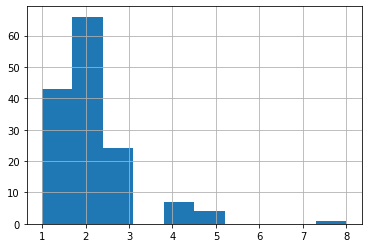

In [ ]:
datos.nvia.str.split().\
    map(lambda x: len(x)).\
    hist()

Most commonly used words on "nvia: nombre de via" for addresses

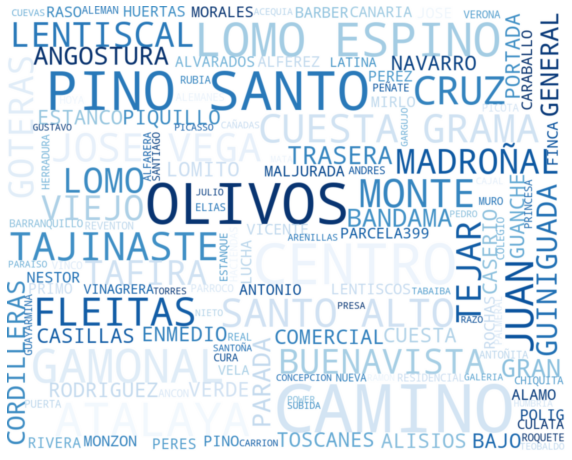

In [ ]:
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'Blues',
                       margin = 0,
                       max_words = 200,
                       min_word_length = 4,
                       max_font_size = 120, min_font_size = 15,
                       background_color = "white").generate(" ".join(datos['nvia']))
plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

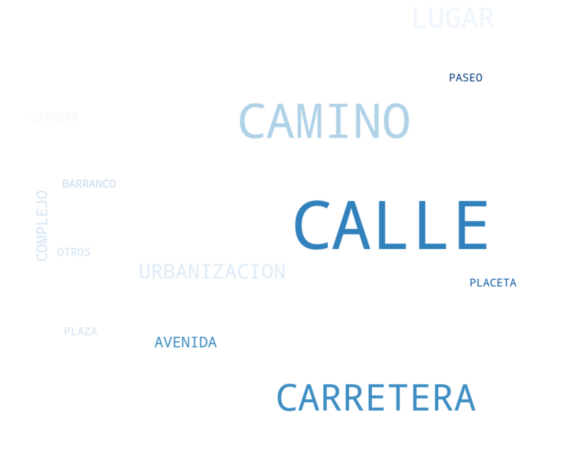

In [ ]:
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'Blues',
                       margin = 0,
                       max_words = 200,
                       min_word_length = 4,
                       max_font_size = 120, min_font_size = 15,
                       background_color = "white").generate(" ".join(datos['tvia']))
plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

In [ ]:
#We create a knew "direccion" column to get root of an address by  removing the nommun who is the same
datos['DIRECC']= datos['tvia']+" " + datos['nvia']+ " " + datos['numer'].map(str)
datos[['tvia','nvia','numer','DIRECC']]

,tvia,nvia,numer,DIRECC
0,CAMINO,TEJAR,28,CAMINO TEJAR 28
1,PASEO,GUINIGUADA,44,PASEO GUINIGUADA 44
2,CALLE,ALFEREZ VICENTE MONZON BARBER,10,CALLE ALFEREZ VICENTE MONZON BARBER 10
3,CALLE,SAN JOSE VEGA,86,CALLE SAN JOSE VEGA 86
4,CALLE,BUENAVISTA,61,CALLE BUENAVISTA 61
...,...,...,...,...
140,CALLE,CAMINO ACEQUIA TAFIRA,4,CALLE CAMINO ACEQUIA TAFIRA 4
141,CAMINO,GAMONAL,121,CAMINO GAMONAL 121
142,CALLE,CASERIO HUMBRIA,16,CALLE CASERIO HUMBRIA 16
143,CALLE,SUBIDA GUANCHE,57,CALLE SUBIDA GUANCHE 57


In [ ]:
#Put adresses in a list format
addresses=datos['DIRECC'].to_list()

In [ ]:
#Put uuid_idt in a list format
uuids=datos['uuid_idt'].to_list() #we need this format for the confusion matrix

Tokenisation

In [ ]:
#Before training the model  we have to put adresses dataset  rightformat format
data = []
# iterate through each address
for i in addresses:
    temp = []
    # tokenize the address into words
    for j in word_tokenize(i):
        temp = [t for t in temp if len(t) > 1]
        temp.append(j)

    data.append(temp)
data

[['CAMINO', 'TEJAR', '28'],
 ['PASEO', 'GUINIGUADA', '44'],
 ['CALLE', 'ALFEREZ', 'VICENTE', 'MONZON', 'BARBER', '10'],
 ['CALLE', 'SAN', 'JOSE', 'VEGA', '86'],
 ['CALLE', 'BUENAVISTA', '61'],
 ['LUGAR', 'CRUZ', 'MORALES', '68'],
 ['LUGAR', 'LOMO', 'ESPINO', '77'],
 ['CALLE', 'NESTOR', 'ALAMO', '60'],
 ['CAMINO', 'PINO', 'SANTO', 'ALTO', '30'],
 ['CALLE', 'MALJURADA', '9'],
 ['CALLE', 'ANGOSTURA', 'TRASERA', '20'],
 ['CALLE', 'FINCA', 'HUERTAS', 'POLIG', 'PARCELA399', '8'],
 ['CALLE', 'CAMINO', 'RASO', 'BANDAMA', '33'],
 ['CAMINO', 'CORDILLERAS', '40'],
 ['URBANIZACION', 'LENTISCOS', '50'],
 ['CARRETERA', 'CENTRO', 'GRAN', 'PARADA', '33'],
 ['CALLE', 'LOMO', 'ESPINO', '104'],
 ['CARRETERA', 'CENTRO', 'JOSE', 'VEGAS', '10'],
 ['CAMINO', 'TEJAR', '32'],
 ['CALLE', 'CAMINO', 'GAMONAL', '11'],
 ['CAMINO', 'CARABALLO', '6'],
 ['CALLE', 'LOMO', 'ESPINO', '334'],
 ['CALLE', 'GENERAL', 'MONTE', 'LENTISCAL', '165'],
 ['CALLE', 'ROCHAS', '52'],
 ['CARRETERA', 'PIQUILLO', 'AL', '28'],
 ['URBANIZA

# Build word2Vec Model

In [ ]:
#Training  model
w2v_model1=  Word2Vec(data, min_count=1,size= 100,workers=1)

In [ ]:
#Loadingg pre-trained model
w2v_model2 = Word2Vec.load("/content/drive/MyDrive/models/complete_model/complete.model")

Vectorization of each adresses

In [ ]:
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

creating vectors with the Word2vec model 1

In [ ]:
w2v_model_1_vectors = vectorize(addresses, model=w2v_model1)
print(w2v_model_1_vectors[0],addresses[0])

[ 3.4710736e-04  6.1734056e-04  1.5635646e-03 -2.0181506e-03
 -1.4554439e-03 -2.3442772e-03 -4.0996545e-03  2.0295859e-04
  1.5807888e-03  7.5199537e-04  1.5787093e-03  2.8594336e-03
 -1.4031131e-04  8.8108971e-04  1.9538021e-03 -1.2508155e-03
 -4.0471731e-03 -1.7134025e-03 -2.8456724e-03 -3.4658937e-03
 -1.5663814e-03  9.1359019e-05 -1.2513219e-03 -1.7040741e-03
  4.5915181e-04 -5.0112349e-04 -2.9938812e-03 -6.7181850e-04
  6.0569425e-04 -6.7090493e-04  1.4979329e-03  3.4300527e-03
  2.3315744e-03 -8.9615636e-04  2.0564583e-03  4.0116068e-04
 -3.1058942e-03  4.6128465e-04  5.4637168e-04  1.4992928e-03
  3.8695480e-03 -7.8109454e-04  4.5174314e-04  3.8608129e-04
 -9.9901779e-05  4.2056181e-03 -2.2900060e-03 -1.7896647e-03
  2.3800377e-03 -2.2375002e-03  2.2398294e-03 -9.9395588e-04
 -1.1212493e-03 -8.5431244e-04 -1.3385919e-03  3.7317842e-03
  2.1369006e-03  1.2218961e-03  2.5403555e-03  2.8741031e-03
  2.4120882e-03  1.7450394e-03  2.9585016e-04 -4.0720003e-03
 -4.3674102e-03 -1.38275

creating vectors with the Word2vec model 2

In [ ]:
w2v_model_2_vectors = vectorize(addresses, model=w2v_model2)
len(w2v_model_1_vectors[0])

100

**Definition of some usefull functions**

Getting cosinus similarity

In [ ]:
def squared_sum(x):
  """ return 3 rounded square rooted value """

  return round(sqrt(sum([a*a for a in x])),3)

In [ ]:
def cos_similarity(x,y):
  """ return cosine similarity between two lists """

  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [ ]:
def calcul_similarity(vects,adr):
  similarity = []
  for i in range(len(adr)):
      row = []
      for j in range(len(adr)):
          row.append(cos_similarity(vects[i],vects[j]))
      similarity.append(row)
  return similarity

Creating Heatmap function

In [ ]:
def create_heatmap(similarity,adr,cmap = "YlGnBu"):
  labels = [headline for headline in adr]
  df = pd.DataFrame(similarity)
  df.columns = labels
  df.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df, cmap=cmap)

Creation Confusion Matrix Function

In [ ]:
def MatrixConfusion(vectors,uuid):
  TP=0
  FP=0
  TN=0
  FN=0
  for k in range(len(uuid)):
    row=[]
    for j in range(len(uuid)):
        if(cos_similarity(vectors[k],vectors[j])>0.9 and uuid[k]==uuid[j]):
          TP=TP+1
        if(cos_similarity(vectors[k],vectors[j])>0.9 and uuid[k]!=uuid[j]):
          FP=FP+1
        if(cos_similarity(vectors[k],vectors[j])<0.9 and uuid[k]==uuid[j]):
          FN=FN+1
        if(cos_similarity(vectors[k],vectors[j])<0.9 and uuid[k]!=uuid[j]):
          TN=TN+1
  Accuracy = (TP+TN)/(TP+FP+TN+FN)
  Precision = TP/(TP+FP)
  Recall=TP/(TP+FN)
  F1=(2*TP)/((2*TP)+FP+FN)
  print("****Confusion Matrix******")
  print("Accuracy : ",Accuracy)
  print("Precision : ",Precision)
  print("Recall : ",Recall)

**Wor2Vec Results**

**1-Model 1 (trained with address dataset)**

**Heatmap**

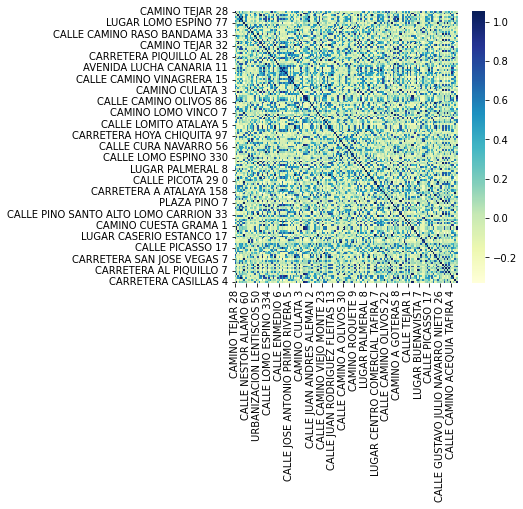

In [ ]:
create_heatmap(calcul_similarity(w2v_model_1_vectors,addresses),addresses)

**Confusion Matrix**

In [ ]:
MatrixConfusion(w2v_model_1_vectors,uuids)

****Confusion Matrix******
Accuracy :  0.976884661117717
Precision :  0.2396694214876033
Recall :  0.847953216374269


**2- Model 2 (loaded from  spanish Word2vec pretrained models )**

**Heatmap**

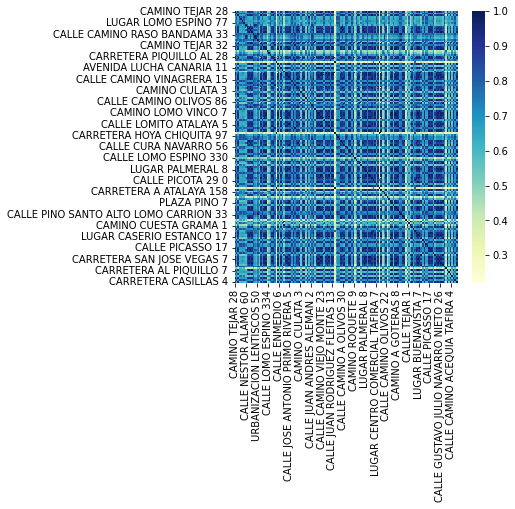

In [ ]:
create_heatmap(calcul_similarity(w2v_model_2_vectors,addresses),addresses)

**Confusion Matrix**

In [ ]:
MatrixConfusion(w2v_model_2_vectors,uuids)

****Confusion Matrix******
Accuracy :  0.3498165880615502
Precision :  0.011809027023110917
Recall :  0.9532163742690059


# Build FastText Models

In [ ]:
#Training Model
fast_Text_model1 = FastText(data,size=100, min_count=1 , workers = 1)

Generating addresses as Vectors with model 1

In [ ]:
fastText_model_1_vectors = vectorize(addresses, model=fast_Text_model1)
len(fastText_model_1_vectors[0])

100

In [ ]:

fastText_model_2 = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/models/fastText/cc.es.300.vec")


In [ ]:
fastText_model_2_vectors = vectorize(addresses, model=fastText_model_2)
len(fastText_model_2_vectors[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


300

**FastText Results**

**1-Model 1 (trained with address dataset)**

**Heatmap**

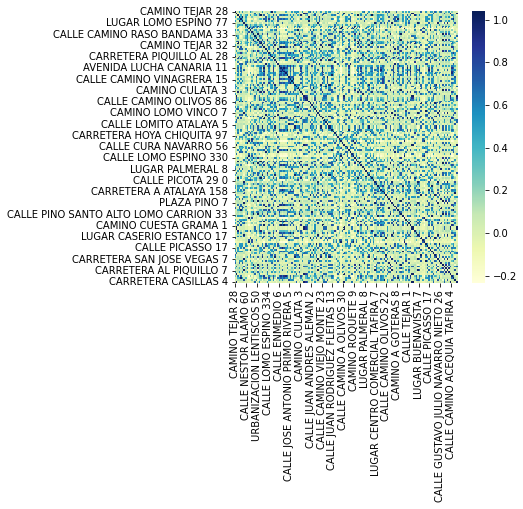

In [ ]:
create_heatmap(calcul_similarity(fastText_model_1_vectors ,addresses),addresses)

**Confusion Matrix**

In [ ]:
MatrixConfusion(fastText_model_1_vectors,uuids)

****Confusion Matrix******
Accuracy :  0.9757293104268786
Precision :  0.23052464228934816
Recall :  0.847953216374269


**2-Model 2 (load a fastext spanish pre-trained model)**

**Heatmap**

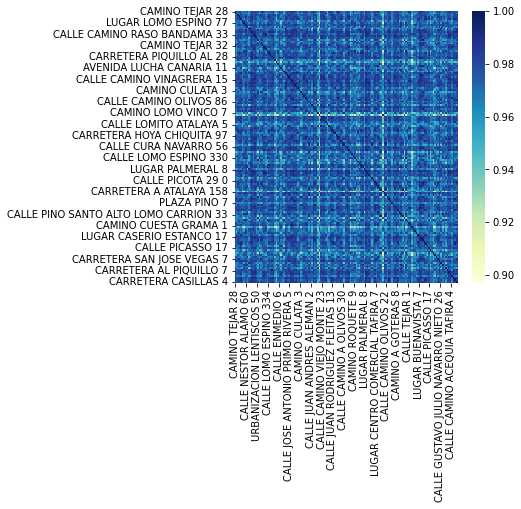

In [ ]:
create_heatmap(calcul_similarity(fastText_model_2_vectors ,addresses),addresses)

**Confusion Matrix**

In [ ]:
MatrixConfusion(fastText_model_2_vectors,uuids)

****Confusion Matrix******
Accuracy :  0.008229865372722515
Precision :  0.0081354964555878
Recall :  1.0


# Build Doc2vec Models

In [ ]:
#initialise the model
doc2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=1, epochs=30)


In [ ]:
#tag Document
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
training_data = list(tagged_document(data))

In [ ]:
#building vocabulary
doc2vec_model.build_vocab(training_data)
#Train the model
doc2vec_model.train(training_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

Generating address as vectors

In [ ]:
doc2vec_vectors = [doc2vec_model.infer_vector([word for word in sent]).reshape(1,-1) for sent in addresses]
print(doc2vec_vectors[0],addresses[0])

[[ 3.8725794e-03 -2.8555156e-03  3.9406796e-03 -3.5004127e-03
   1.1261054e-03  1.0056059e-03  3.4530240e-04  2.1024782e-03
  -3.4922992e-03  4.2337101e-04 -4.9889493e-03  3.0216267e-03
  -1.6247570e-03  3.9080819e-03 -3.6219468e-03  2.6952433e-03
  -3.0160772e-03  3.5291538e-04  1.8798895e-03  2.4334241e-03
   4.3309340e-03  3.7124828e-03 -4.3348232e-03  3.2667280e-03
  -5.6911269e-03 -4.4914898e-03 -1.9426185e-04 -1.7271489e-03
   2.7135054e-03  2.4005233e-03 -2.3766267e-03  4.0240306e-03
   6.8113342e-04 -1.7141921e-03  5.4833721e-03  1.6357994e-03
  -1.2626870e-03  1.3686012e-03  5.7140719e-03  2.0415406e-03
   6.0589551e-03 -1.0748123e-03 -8.2384534e-03 -9.7961759e-04
   5.1435288e-03 -3.5866937e-03 -5.0675245e-03 -3.0370944e-03
   3.2777623e-03 -3.4257695e-03  5.3752288e-03 -2.3003141e-03
  -2.4783111e-03  1.7671481e-03  2.0424204e-03  4.9910699e-03
   2.1310302e-03  6.8800146e-04 -1.7196159e-03 -3.6570807e-03
  -5.4788718e-04  3.9164975e-04 -3.6894130e-03  2.9537696e-03
  -2.037

We need to Make some changes to deal with with cos_similarity on doc2vec

In [ ]:
sim = []
for i in range(len(addresses)):
    row = []
    for j in range(len(addresses)):
        row.append(cos_similarity(doc2vec_vectors[i][0],doc2vec_vectors[j][0]))
    sim.append(row)

In [ ]:
def MatrixConfusion_doc(vectors,uuid):
  TP=0
  FP=0
  TN=0
  FN=0
  for k in range(len(uuid)):
    row=[]
    for j in range(len(uuid)):
        if(cos_similarity(vectors[k][0],vectors[j][0])>0.9 and uuid[k]==uuid[j]):
          TP=TP+1
        if(cos_similarity(vectors[k][0],vectors[j][0])>0.9 and uuid[k]!=uuid[j]):
          FP=FP+1
        if(cos_similarity(vectors[k][0],vectors[j][0])<0.9 and uuid[k]==uuid[j]):
          FN=FN+1
        if(cos_similarity(vectors[k][0],vectors[j][0])<0.9 and uuid[k]!=uuid[j]):
          TN=TN+1
  Accuracy = (TP+TN)/(TP+FP+TN+FN)
  Precision = TP/(TP+FP)
  Recall=TP/(TP+FN)
  F1=(2*TP)/((2*TP)+FP+FN)
  print("****Confusion Matrix******")
  print("Accuracy : ",Accuracy)
  print("Precision : ",Precision)
  print("Recall : ",Recall)

**Doc2Vec Results**

**Heatmap**

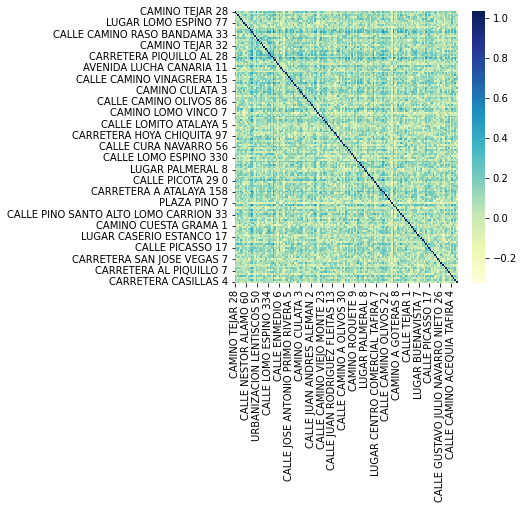

In [ ]:
create_heatmap(sim,addresses)

**Confusion Matrix**

In [ ]:
MatrixConfusion_doc(doc2vec_vectors,uuids)

****Confusion Matrix******
Accuracy :  0.9987633769322235
Precision :  1.0
Recall :  0.847953216374269


# BERT spanish Model

Installing Tranformer

In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 4.7 MB 51.1 MB/s 
     |████████████████████████████████| 1.3 MB 37.0 MB/s 
     |████████████████████████████████| 120 kB 55.8 MB/s 
     |████████████████████████████████| 6.6 MB 40.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=e5cccb8ebd42f0b034f4017c85a9df1a3ef3ebd0ce3faf6dd5b01a2350fc7d19
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
#Loading Tranformers
from sentence_transformers import SentenceTransformer

Loading a Spanish BERT model

In [ ]:

bert_model = SentenceTransformer('hackathon-pln-es/paraphrase-spanish-distilroberta')


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/123 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/514k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/354 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/855k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

generating addresses as vectors

In [ ]:
bert_vectors = bert_model.encode(addresses)
bert_vectors.shape

(145, 768)

**BERT results**

**Heatmap**

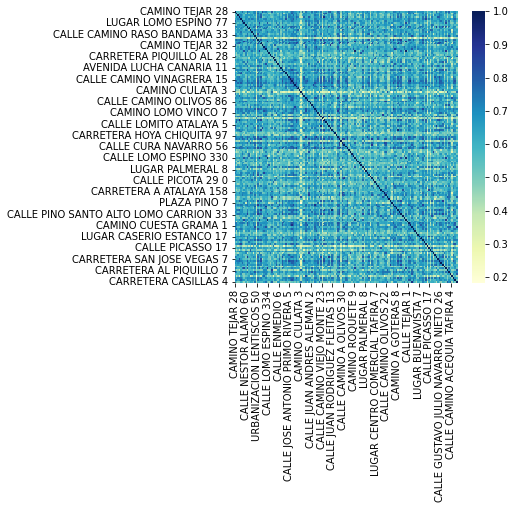

In [ ]:
create_heatmap(calcul_similarity(bert_vectors,addresses),addresses)

**Confusion Matrix**

In [ ]:
MatrixConfusion(bert_vectors,uuids)

****Confusion Matrix******
Accuracy :  0.9970508490700661
Precision :  0.8011049723756906
Recall :  0.847953216374269
